In [8]:
# TODO: tidy

# The affine field representation

In general, the parametric affine coefficient field is given by 

***

\begin{equation}
  a(x, y) = s*\left(a_0(x) + \sum_{m=1}^\infty a_m(x)y_m\right)
\end{equation}

***

where $s\in\mathbb{R}$ is a scaling factor, $a_0$ is the mean and $a_m$ for $m>0$ are the deterministic coefficient function and $y_m\in\mathbb{R}$ is the image of a random variable.
In our setting, $y_m$ stems from a random variable $Y_m$ which is distributed either $Y_m\sim\mathcal{U}(a, b)$ or $Y_m\sim\mathcal{N}(\mu, \sigma)$. 
By default, $a=-1$, $b=1$ and $\mu=0$, $\sigma=1$.

***

The amplification functions $a_m(x)=\alpha_m t_m(x)$ are defined by a decay function $\alpha_m$ and a coefficient function $t_m(x):\colon D\to\mathbb{R}$.
The decay $\alpha_m$ can be set to the following:
- "decay-inf": The $\alpha_m$ model a converging decay such that $\alpha_m = \bar{\alpha}m^{-\sigma}$ with some decay $\sigma>0$ and mean scaling $0 < \bar{\alpha} < \frac{\gamma}{\zeta(\sigma)}$.
Here, $\gamma<1$ is another steering parameter and $\zeta(\cdot)$ is the Riemann zeta function.
Note that, this series does not converge in general for $\sigma < 1$.

***

- "decay-algebraic": A simplified algebraically decaying coefficient field with 
***
\begin{equation}
  \alpha_m = \left(\frac{\gamma}{m}\right)^\sigma.
\end{equation}
***
Again, $\gamma<1$ is a constant scaling factor and $\sigma>0$ denotes the decay rate.

- "decay-exponential": An exponentially decaying coefficient field of type
***
\begin{equation}
  \alpha_m = \exp\left(-\sigma m)\right).
\end{equation}
***
- "constant": A constant, non decaying field
***
\begin{equation}
  \alpha_m = \gamma.
\end{equation}
***
This field does not converge but is used to model truncated fields with equal contributions.

***

On the other hand, the base coefficient functions can be set to:
- "cos"/"sin":  The functions are choosen, such that they iterate all planar fourier modes in total increasing order. 
This means, 
***
\begin{equation}
  t_m(x) = t(c 2\pi\rho_1(m)x_1)t(c 2\pi\rho_2(m)x_2), \quad t\in{sin, cos}
\end{equation}
***
where $c\in\mathbb{R}$ is a frequency scaling factor and $\rho_1$, $\rho_2$ iterate a complete ordered set, i.e.
***
\begin{equation}
  \rho_1(m) = m - \frac{k(m)(k(m)+1)}{2}, \qquad \text{and} \qquad \rho_2(m) = k(m) - \rho_1(m),
\end{equation}
***
with 
***
\begin{equation}
  k(m) = \lfloor -\frac{1}{2} + \sqrt{\frac{1}{4} + 2m}\rfloor.
\end{equation}
***

- "monomials": Usual monomial polynomial basis functions
***
\begin{equation}
  t_m(x) = x^{c m},
\end{equation}
***
with scaling factor $c\in\mathbb{R}$.

- "constant": Models a constant field with $t_m(x) = 1$. 
Note that, even the scaling factor $\alpha_m=1$ is set to one. 
This mean, the field degerenates to 
***
\begin{equation}
  a(x, y) = a_0(x) + \sum_{m=1}^\infty y_m.
\end{equation}
***
- "deterministic": Sets the overall coefficient field equal to the mean, i.e. $t_m(x) = 0$.

***

Be aware, to define a postive definite coefficient field, not all implementations are valid.
Sometimes, manual scaling is needed.

***

The setting "cos, decay-inf" is used in [EGSZ1, EGSZ2, EMS, EPS, EMPS].

In [1]:
from __future__ import (division, print_function)
from alea.math_utils.param_pde.affine_field import AffineField
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

A simplified version of the alea coefficient fields is implemented in the following. 
We want to show the equivalence to the analytical formulations above.

In [6]:
from scipy.special import zeta
def get_decay_start(exp, gamma=1):
    start = 1
    while zeta(exp, start) >= gamma:
        start += 1
    return start

def get_ampfunc(amptype, decayexp, gamma):
    if amptype == "decay-inf":
        start = get_decay_start(decayexp, gamma)
        amp = gamma / zeta(decayexp, start)
        ampfunc = lambda i: amp / (float(i) + start) ** decayexp
    elif amptype == "decay-algebraic":
        ampfunc = lambda i: gamma / (float(i) + 1) ** decayexp
    elif amptype == "decay-exponential":
        ampfunc = lambda i: np.exp(-decayexp * (i + 1))
    elif amptype == "constant":
        ampfunc = lambda i: gamma
    else:
        raise ValueError("Unknown amplitude type {}".format(amptype))
    return ampfunc

def ref_field(y,                                 # type: np.ndarray
              fs,                                # type: FunctionSpace
              coef_type="cos",                   # type: str
              amptype="decay-inf",               # type: str
              decayexp=2,                        # type: float
              gamma=0.9,                         # type: float
              freqscale=1.0,                     # type: float
              freqskip=0,                        # type: int
              scale=1.0,                         # type: float
              coef_mean=0.0,                     # type: float
              rv_type="uniform",                 # type: str
              discretisation="interpolate"       # type: str
             ):
    
    def indexer(i):
        def _k(m):
            return np.floor(-0.5+np.sqrt(1/4+2*m))
        def rho_1(m):
            return m - _k(m)*(_k(m)+1)*0.5
        def rho_2(m):
            return _k(m) - rho_1(m)
        return int(rho_1(i)), int(rho_2(i))
    
    ex_opt = {"freq": freqscale, "degree": 10, "B": scale}
    retval = Expression("A*B", A=coef_mean, B=scale, degree=10)
    retval = interpolate(retval, fs)
    for i in range(freqskip, len(y)):
        m, n = indexer(i+1)
        ex_opt["n"] = n
        ex_opt["m"] = m
        ex_opt["A"] = get_ampfunc(amptype, decayexp, gamma)(i)
        if coef_type == "cos":
            a_m = Expression("A*B*cos(freq*pi*m*x[0])*cos(freq*pi*n*x[1])", **ex_opt)
        elif coef_type == "sin":
            a_m = Expression("A*B*sin(freq*pi*(m+1)*x[0])*sin(freq*pi*(n+1)*x[1])", **ex_opt)
        elif coef_type == "monomials":
            a_m = Expression("A*B*pow(x[0],freq*m)*pow(x[1],freq*n)", **ex_opt)
        elif coef_type == "constant":
            a_m = Expression("1.0+A-A+B-B", **ex_opt)
        elif coef_type == "deterministic":
            a_m = Expression("0.0+A-A+B-B", **ex_opt)
        else:
            raise ValueError("unknown coefficient type")
        if discretisation == "interpolate":
            retval.vector()[:] += y[i]*interpolate(a_m, fs).vector()
        elif discretisation == "project":
            retval.vector()[:] += y[i]*project(a_m, fs).vector()
    return retval

In [9]:
coef_options = {
    "coef_type": "cos",
    "amptype": "decay-inf",
    "decayexp": 2,
    "gamma": 0.9,
    "freqscale": 1.0,
    "freqskip": 0,
    "rv_type": "uniform",
    "scale": 1.0,
    "coef_mean": 1.0,
    "discretisation": "project"
}

def plot_fields(alea, ref):
    mpl.rcParams['figure.figsize'] = [12, 4]
    fig = plt.figure()

    ax = plt.subplot(131)
    im = plot(alea)
    plt.title("alea")
    plt.colorbar(im, format="%.3f")

    ax = plt.subplot(132)
    im = plot(ref)
    plt.title("Reference")
    plt.colorbar(im, format="%.3f")

    ax = plt.subplot(133)
    diff = Function(fs)
    diff.vector().set_local(np.abs(ref.vector().array() - alea.vector().array()))
    im = plot(diff)
    plt.title("Difference")
    plt.colorbar(im)

    plt.tight_layout()    


M = 10
mesh = UnitSquareMesh(10, 10)
fs = FunctionSpace(mesh, 'CG', 1)
y = np.random.rand(M)*2 - 1

decay-inf with basis functions: cos


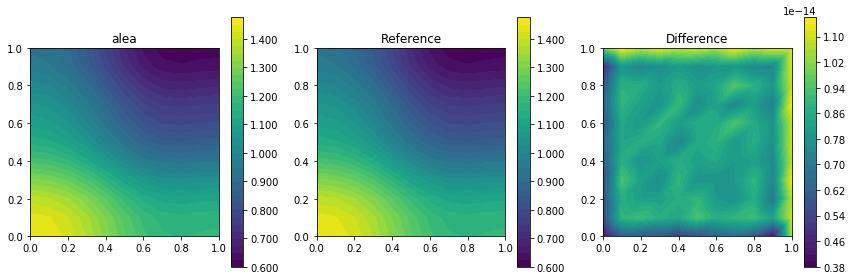

decay-inf with basis functions: sin


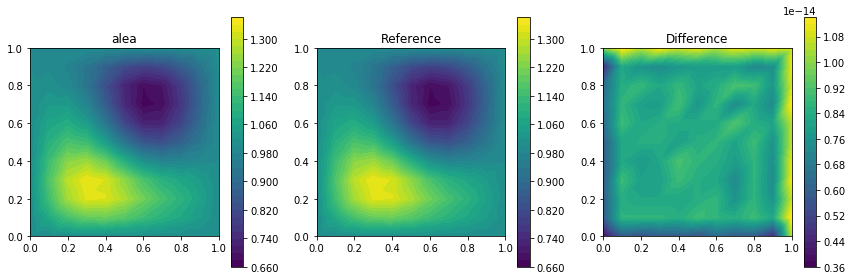

decay-inf with basis functions: monomials


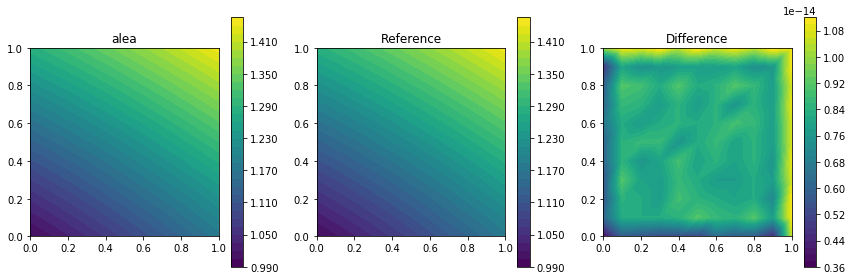

decay-inf with basis functions: constant


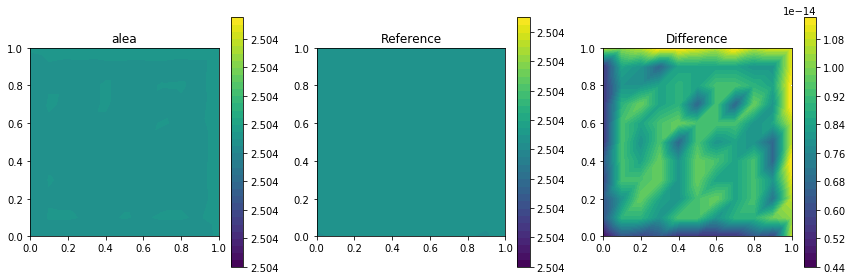

decay-inf with basis functions: deterministic


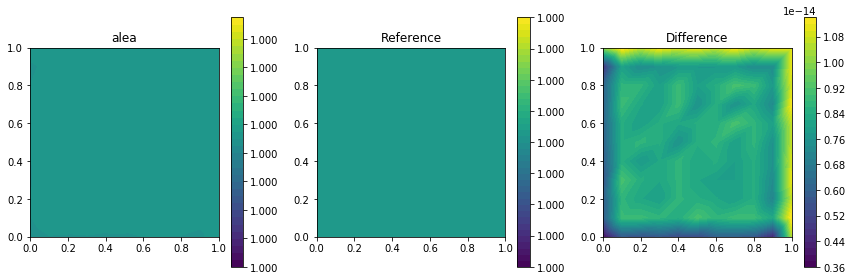

In [10]:
coef_options["amptype"] = "decay-inf"
for coef_type in ["cos", "sin", "monomials", "constant", "deterministic"]:
    coef_options["coef_type"] = coef_type
    print("decay-inf with basis functions: {}".format(coef_type))
    
    field = AffineField(**coef_options)
    kappa = field(y, fs, project_result=True)
    kappa_ref = ref_field(y, fs, **coef_options)

    plot_fields(kappa, kappa_ref)
    plt.show()

decay-algebraic with basis functions: cos


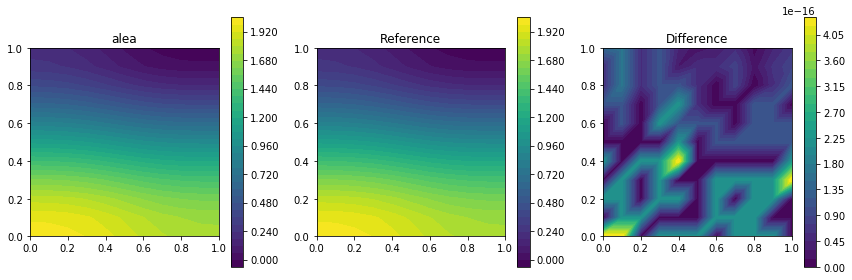

decay-algebraic with basis functions: sin


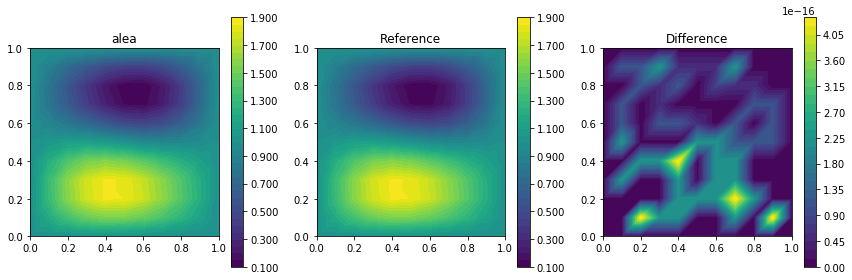

decay-algebraic with basis functions: monomials


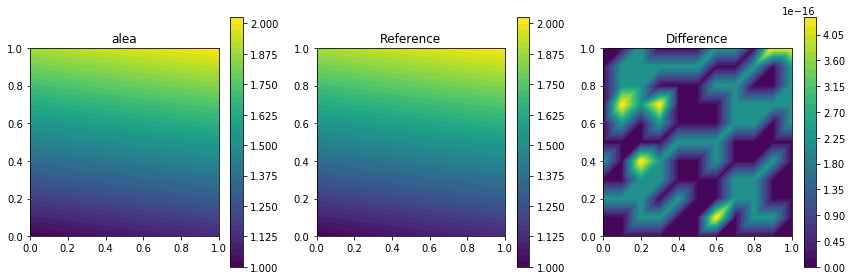

decay-algebraic with basis functions: constant


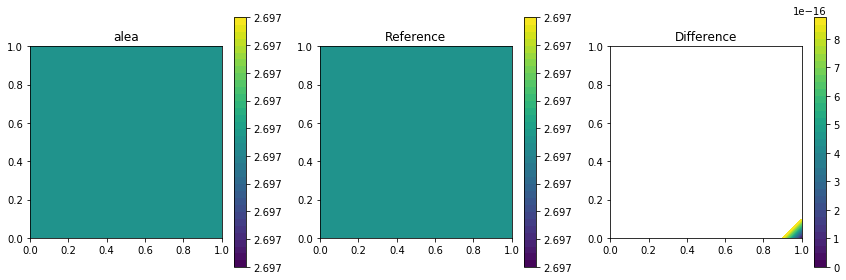

decay-algebraic with basis functions: deterministic


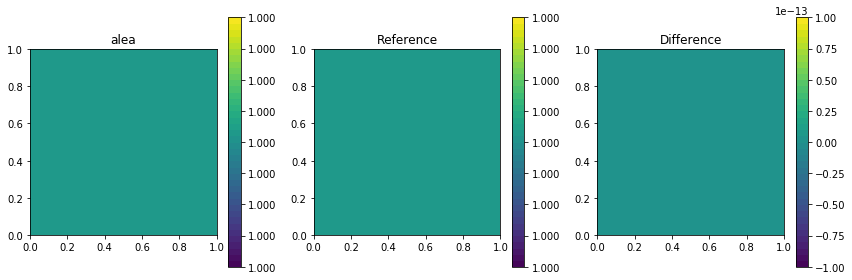

In [5]:
coef_options["amptype"] = "decay-algebraic"
for coef_type in ["cos", "sin", "monomials", "constant", "deterministic"]:
    coef_options["coef_type"] = coef_type
    print("decay-algebraic with basis functions: {}".format(coef_type))
    
    field = AffineField(**coef_options)
    kappa = field(y, fs, project_result=True)
    kappa_ref = ref_field(y, fs, **coef_options)
    
    plot_fields(kappa, kappa_ref)
    plt.show()

decay-exponential with basis functions: cos


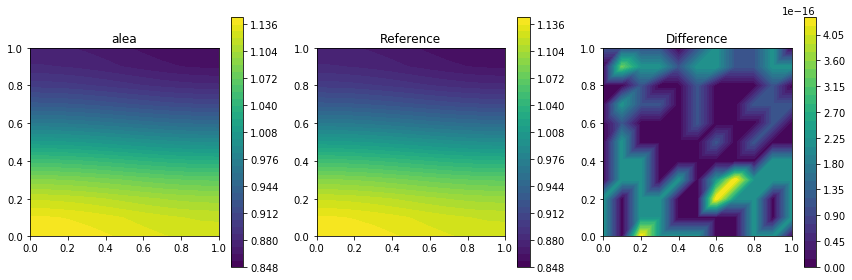

decay-exponential with basis functions: sin


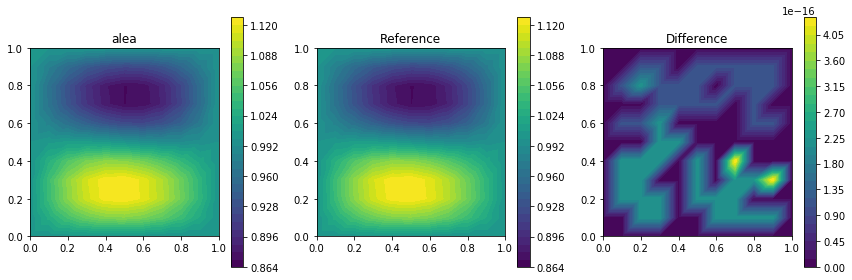

decay-exponential with basis functions: monomials


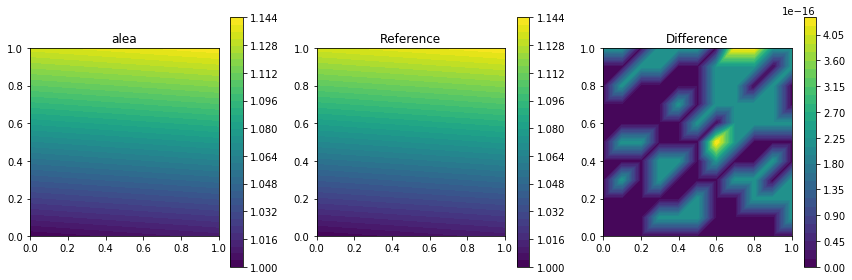

decay-exponential with basis functions: constant


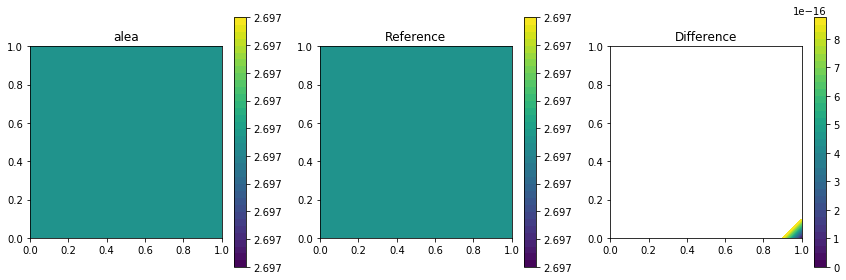

decay-exponential with basis functions: deterministic


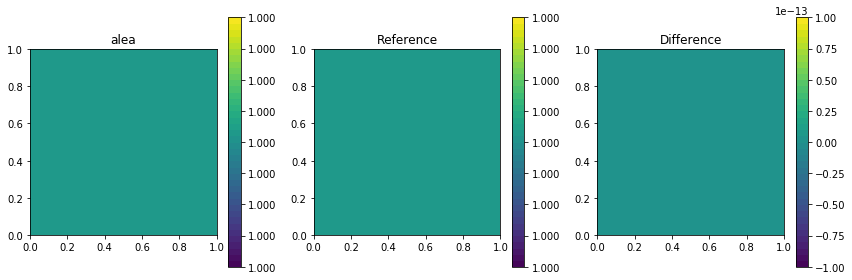

In [6]:
coef_options["amptype"] = "decay-exponential"
for coef_type in ["cos", "sin", "monomials", "constant", "deterministic"]:
    coef_options["coef_type"] = coef_type
    print("decay-exponential with basis functions: {}".format(coef_type))
    
    field = AffineField(**coef_options)
    kappa = field(y, fs, project_result=True)
    kappa_ref = ref_field(y, fs, **coef_options)
    
    plot_fields(kappa, kappa_ref)
    plt.show()

constant with basis functions: cos


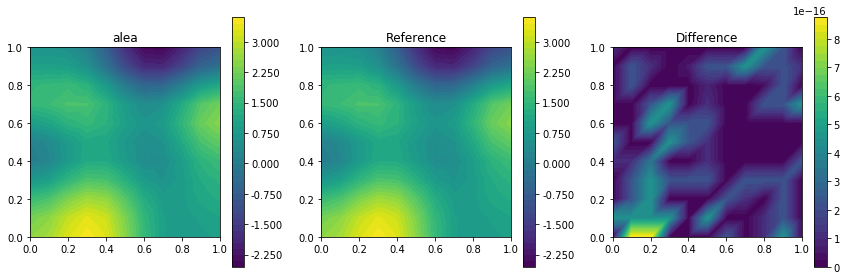

constant with basis functions: sin


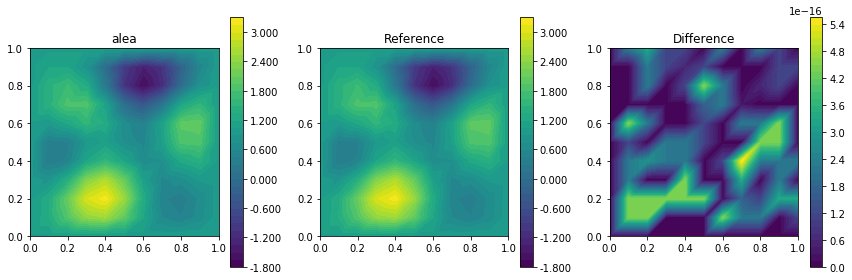

constant with basis functions: monomials


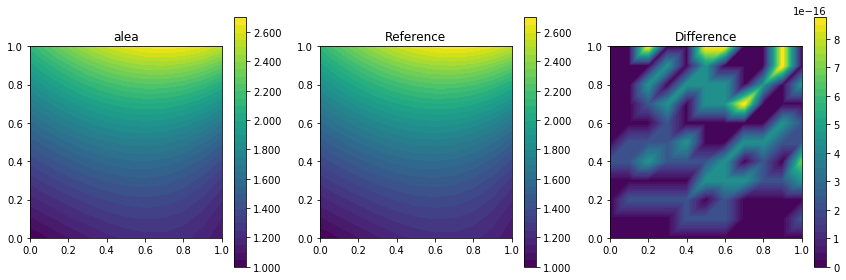

constant with basis functions: constant


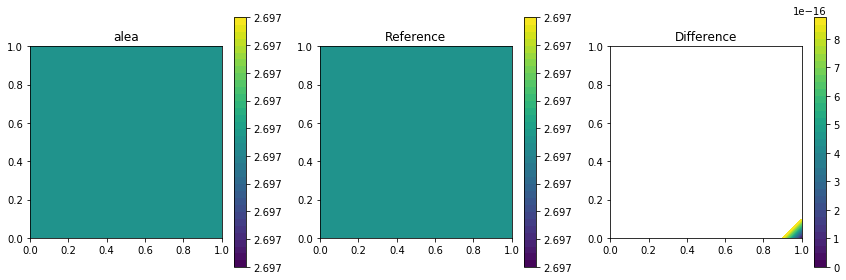

constant with basis functions: deterministic


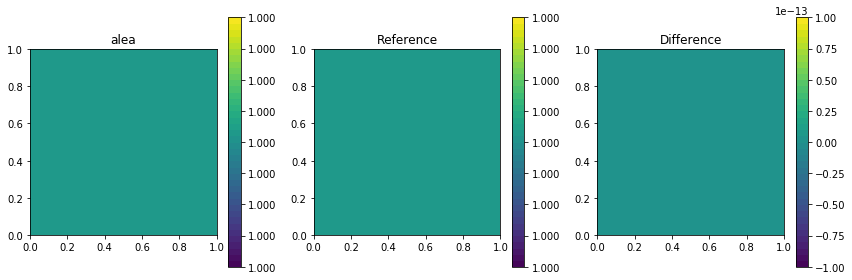

In [7]:
coef_options["amptype"] = "constant"
for coef_type in ["cos", "sin", "monomials", "constant", "deterministic"]:
    coef_options["coef_type"] = coef_type
    print("constant with basis functions: {}".format(coef_type))
    
    field = AffineField(**coef_options)
    kappa = field(y, fs, project_result=True)
    kappa_ref = ref_field(y, fs, **coef_options)
    plot_fields(kappa, kappa_ref)
    plt.show()